<a href="https://colab.research.google.com/github/riyafang/ECON430_Project/blob/main/ECON430_Prj1_V10_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECON 430_PROJECT 1
### GROUP MEMBER: Roman LUO, Wayne CAI, Amber YU, Ruiya FANG

In [ ]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random; random.seed(10) # pre-setting seed
from scipy import stats
from scipy.stats import norm, chi2, f
from ydata_profiling import ProfileReport
# numpy version matters for scipy

# for model fitting
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.graphics import regressionplots
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import metrics

# subset regressions & feature selection
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# heteroskedasticity
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, het_goldfeldquandt

# missing data imputation
from sklearn.impute import KNNImputer
from statsmodels.imputation import mice

# for R kernel
# note: need working copy of R, initiate chunk with `%%R`
import rpy2.ipython
%load_ext rpy2.ipython

In [ ]:
import kagglehub

# download latest version of the kaggle dataset
path = kagglehub.dataset_download("lainguyn123/student-performance-factors")

print("Path to dataset files:", path)

Path to dataset files: /Users/fangruiya/.cache/kagglehub/datasets/lainguyn123/student-performance-factors/versions/6


In [ ]:
data_file = path + "/StudentPerformanceFactors.csv"

## Motivation:

Through the analysis we are trying to figure out :
1. what is the most important factor in all 19 explaining variableson on final exam score
2. This factor can leverage the exam score in what extend

# I. Descriptive Analysis

In [ ]:
# show data structure
data = pd.read_csv(data_file)
data.head()
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

Hours_Studied   Attendance  Sleep_Hours  Previous_Scores  \
count    6607.000000  6607.000000   6607.00000      6607.000000   
mean       19.975329    79.977448      7.02906        75.070531   
std         5.990594    11.547475      1.46812        14.399784   
min         1.000000    60.000000      4.00000        50.000000   
25%        16.000000    70.000000      6.00000        63.000000   
50%        20.000000    80.000000      7.00000        75.000000   
75%        24.000000    90.000000      8.00000        88.000000   
max        44.000000   100.000000     10.00000       100.000000   

       Tutoring_Sessions  Physical_Activity   Exam_Score  
count        6607.000000        6607.000000  6607.000000  
mean            1.493719           2.967610    67.235659  
std             1.230570           1.031231     3.890456  
min             0.000000           0.000000    55.000000  
25%             1.000000           2.000000    65.000000  
50%             1.000000           3.000000    67.000000  
75%             2.000000           4.000000    69.000000  
max             8.000000           6.000000   101.000000



## 0. Pre-analysis data cleaning process



1. We mapped ordinal data to numeric values `1/2/3`:  
- "Low"/"Medium"/"High" → 1/2/3
- "High School"/"College"/"Postgraduate" → 1/2/3
- "Far"/"Moderate"/"Near" → 1/2/3

2. We converted binary categorical data to numeric values `0/1`:
- "Positive"/"Negative" → 1/0
- "Male"/"Female" → 1/0
- "Yes"/"No" → 1/0
- "Private"/"Public" → 1/0

3. We mapped trinary data to numeric values `1/0/-1`:
- "Positive"/"Neutral"/"Negative" → 1/0/-1

In [ ]:
# converting categorical data into numeric values
data['Parental_Involvement'] = data['Parental_Involvement'].replace({'Low': 1, 'Medium': 2, 'High': 3})
data['Access_to_Resources'] = data['Access_to_Resources'].replace({'Low': 1, 'Medium': 2, 'High': 3})
data['Extracurricular_Activities'] = data['Extracurricular_Activities'].replace({'Yes': 1, 'No': 0})
data['Motivation_Level'] = data['Motivation_Level'].replace({'Low': 1, 'Medium': 2, 'High': 3})
data['Internet_Access'] = data['Internet_Access'].replace({'Yes': 1, 'No': 0})
data['Family_Income'] = data['Family_Income'].replace({'Low': 1, 'Medium': 2, 'High': 3})
data['Teacher_Quality'] = data['Teacher_Quality'].replace({'Low': 1, 'Medium': 2, 'High': 3})
data['School_Type'] = data['School_Type'].replace({'Private': 1, 'Public': 0})
data['Peer_Influence'] = data['Peer_Influence'].replace({'Negative': -1, 'Neutral': 0, 'Positive': 1})
data['Learning_Disabilities'] = data['Learning_Disabilities'].replace({'Yes': 1, 'No': 0})
data['Parental_Education_Level'] = data['Parental_Education_Level'].replace({'High School': 1, 'College': 2, 'Postgraduate': 3})
data['Distance_from_Home'] = data['Distance_from_Home'].replace({'Far': 1, 'Moderate': 2, 'Near': 3})
data['Gender'] = data['Gender'].replace({'Male': 1, 'Female': 0})



## 1. Histograms

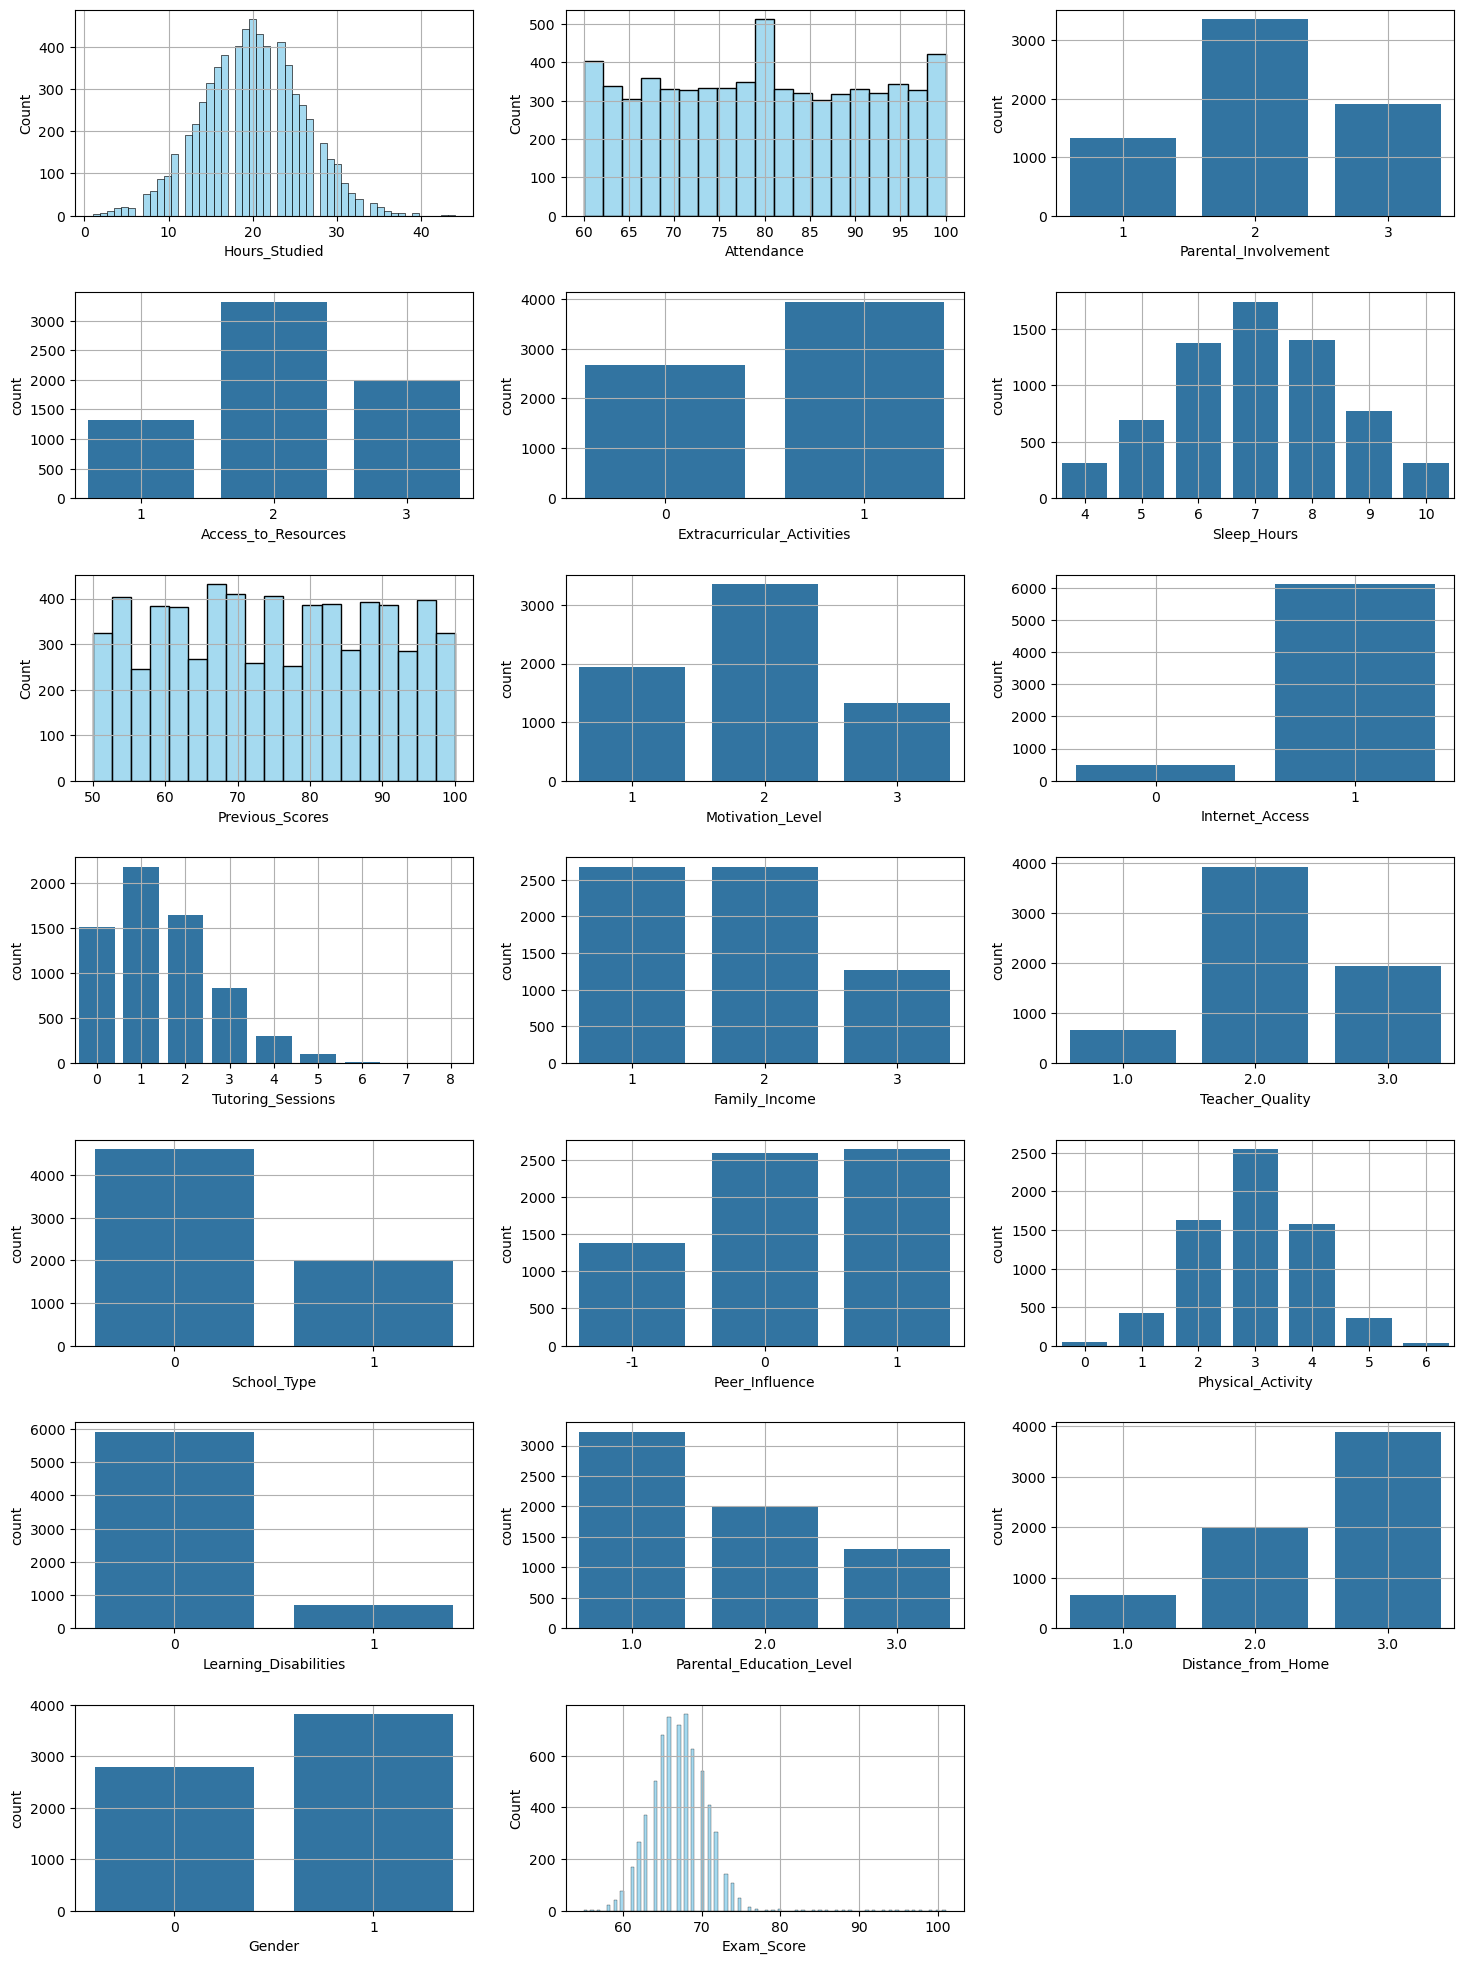

In [ ]:
# seperating discrete and continuous variables
variables = ['Hours_Studied', 'Attendance', 'Parental_Involvement', 'Access_to_Resources',
             'Extracurricular_Activities', 'Sleep_Hours', 'Previous_Scores', 'Motivation_Level',
             'Internet_Access', 'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality',
             'School_Type', 'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities',
             'Parental_Education_Level', 'Distance_from_Home', 'Gender', 'Exam_Score']

binary_trinary_vars = ['Gender', 'Distance_from_Home', 'Physical_Activity', 'School_Type', 'Teacher_Quality',
                       'Internet_Access', 'Parental_Involvement', 'Family_Income', 'Tutoring_Sessions',
                       'Motivation_Level', 'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours',
                       'Learning_Disabilities', 'Peer_Influence', 'Parental_Education_Level']

# plotting
rows = 7
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 20))

axes = axes.flatten()

for i, var in enumerate(variables):
    if var in binary_trinary_vars:
        sns.countplot(x=data[var], ax=axes[i])    # countplot for discrete variables
    else:
        sns.histplot(data[var], kde=False, ax=axes[i], color='skyblue', edgecolor='black')    # histogram for discrete and continuous variables

    # axes[i].set_title(var, fontsize=10)    # titles seem redundant
    axes[i].grid(True)

for i in range(len(variables), len(axes)):
    fig.delaxes(axes[i])

# show plots
plt.tight_layout(pad=2.0)
plt.show()

## 2.  Quantile Plots

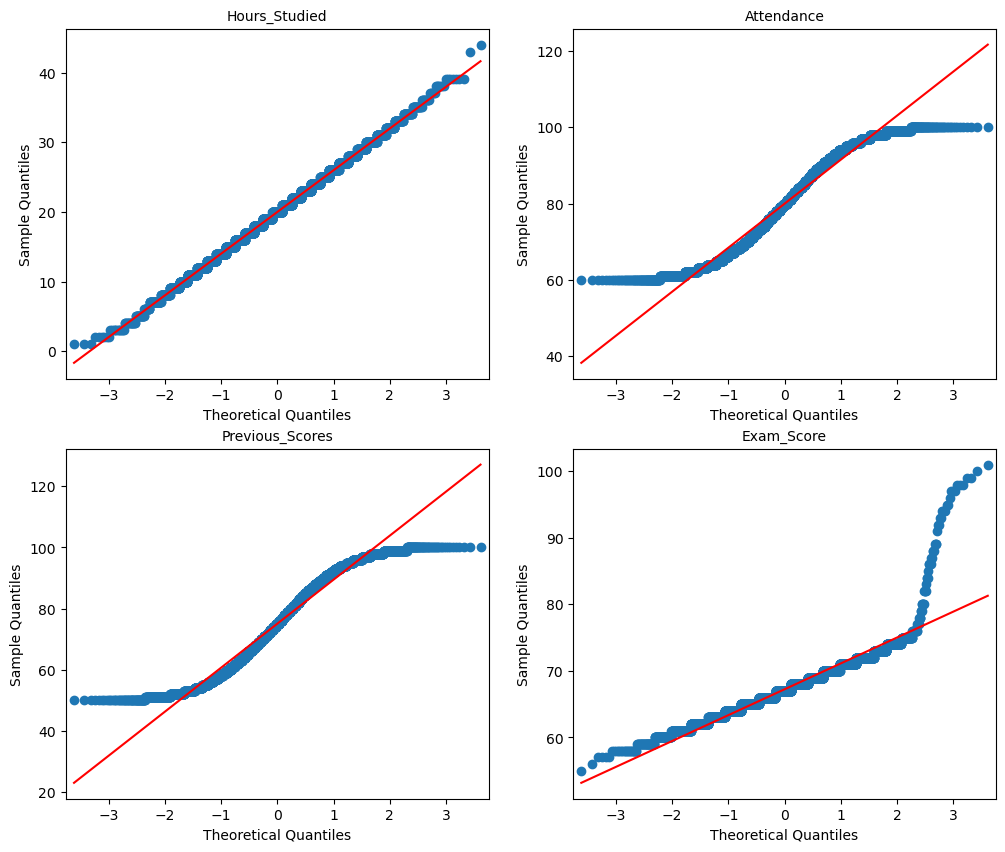

In [ ]:
fig2, axes2 = plt.subplots(2, 2, figsize=(12, 10))

axes2 = axes2.flatten()

i = 0
for var in variables:
    if var not in binary_trinary_vars:
        sm.qqplot(data[var], line='s', ax=axes2[i])
        axes2[i].set_title(var, fontsize=10)
        i += 1

plt.show()

## 3.  Correlation Plots

Text(0.5, 1.0, 'Correlation Matrix')

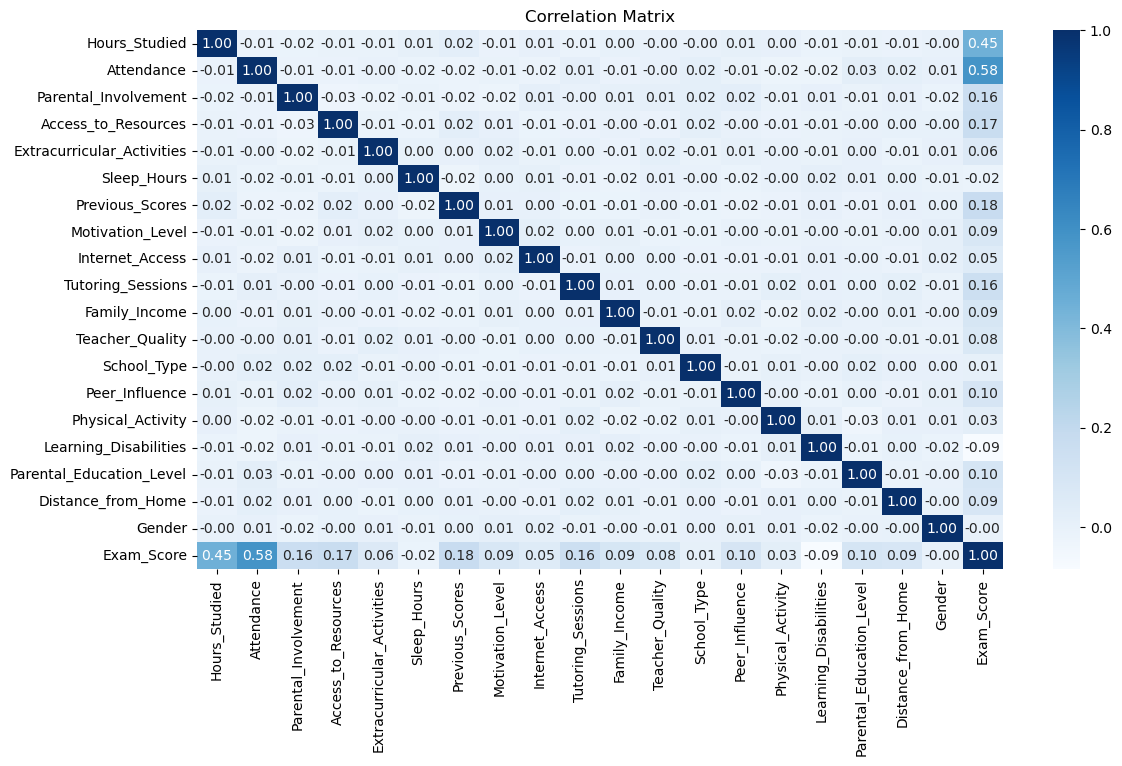

In [ ]:
plt.figure(figsize=(13,7))
c=data.corr()
sns.heatmap(c,annot=True, fmt=".2f", cmap="Blues")
plt.title('Correlation Matrix')

## 4. Pandas Profiling

In [ ]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

For variable `Hours_Studied` there are unusual high frequency around 800 in [22,23] hours, comparing to 0-400.

## 5. Density Distributions

In [ ]:
# porting data_file into R
%R  -i data_file

summary statistics
------
min:  1   max:  44 
median:  20 
mean:  19.97533 
estimated sd:  5.990594 
estimated skewness:  0.01349891 
estimated kurtosis:  3.017771 


Loading required package: MASS
Loading required package: survival
In addition: Warning message:
In data(edu_data) : data set ‘edu_data’ not found


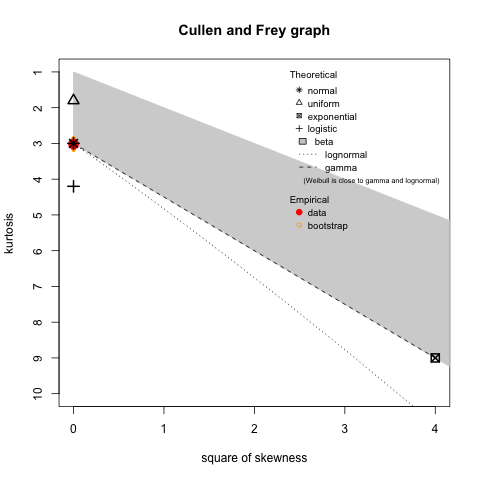

In [ ]:
%%R

# reading data in R
edu_data <- read.csv(data_file)

set.seed(10) # for bootstrap
library("fitdistrplus")
data(edu_data)

# Cullen-Frey Graph
descdist(edu_data$Hours_Studied, boot = 1000)



*   Hours_Studied
>  From G&F graph the estimated dsitribution of Hours_Studied is normal distribution.






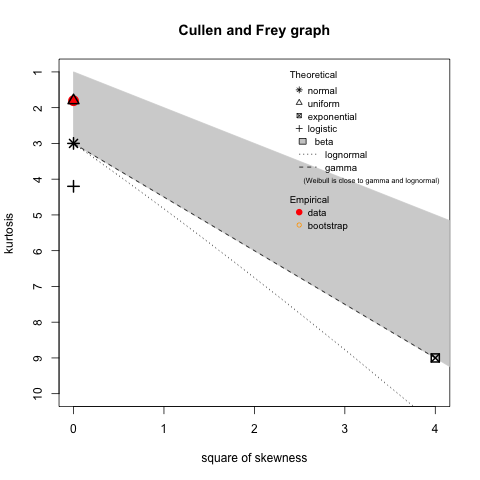

o{'min': [60], 'max': [100], 'median': [80], 'mean': [79.97744816], 'sd': [11.54747496], 'skewness': [0.01366586], 'kurtosis': [1.80559335], 'method': ['unbiased'], }

In [ ]:
%R descdist(edu_data$Attendance, boot = 1000)

- Attendance
> Uniform distribution

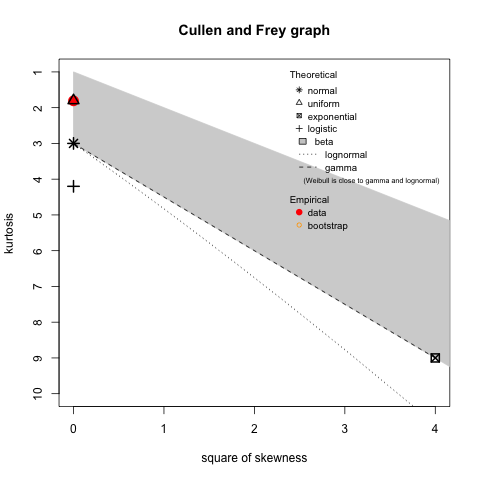

o{'min': [50], 'max': [100], 'median': [75], 'mean': [75.07053125], 'sd': [14.39978435], 'skewness': [-0.00373653], 'kurtosis': [1.80891959], 'method': ['unbiased'], }

In [ ]:
%R descdist(edu_data$Previous_Scores, boot = 1000)

- Previous Socres
> Uniform dsitribution

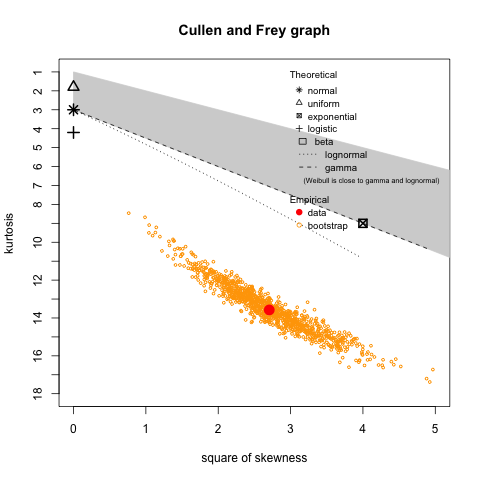

o{'min': [55], 'max': [101], 'median': [67], 'mean': [67.23565915], 'sd': [3.89045578], 'skewness': [1.64480829], 'kurtosis': [13.57542273], 'method': ['unbiased'], }

In [ ]:
%R descdist(edu_data$Exam_Score, boot = 1000)

*  Exam_scores
>  Cannot determine

## 6. Non-linearities

All 15 potential predictors seems linear, nice and clean.

However, our reponse variable, `Exam_Score`, exhibits certain degree of non-linearity in that:

- The histogram shows that the distribution of `Exam_Score` is left-skewed, indicating that the majority of scores are concentrated in a relatively narrow range (60-70), with some lower outliers.

- The Q-Q plot shows data points deviating from the diagonal line at both ends. This is a sign that the variable is not normally distributed in the tails. The higher values are particularly heavier than expected in a normal distribution, meaning there are more extreme high values than expected for a normal distribution.

- The Cullen and Frey Graph shows that the data has a high kurtosis and high skewness. It also places the data closer (if any) to a lognormal or gamma distribution rather than a normal distribution, which further neccesitates a transformation on this variable.

Thus we performed a Box-Cox scale power transformation, which indicates that a log transformation is appropriate.

In [ ]:
%%R

# doing box-cox

library(car)
bc <- powerTransform(edu_data$Exam_Score ~ 1)

summary(bc)

bcPower Transformation to Normality 
   Est Power Rounded Pwr Wald Lwr Bnd Wald Upr Bnd
Y1   -2.6107       -2.61      -2.8795       -2.342

Likelihood ratio test that transformation parameter is equal to 0
 (log transformation)
                           LRT df       pval
LR test, lambda = (0) 431.2467  1 < 2.22e-16

Likelihood ratio test that no transformation is needed
                           LRT df       pval
LR test, lambda = (1) 891.0391  1 < 2.22e-16


In [ ]:
# try out log transformation
data = data.copy()
data['l_Exam_Score'] = np.log(data['Exam_Score'])

summary statistics
------
min:  4.007333   max:  4.615121 
median:  4.204693 
mean:  4.206606 
estimated sd:  0.05597356 
estimated skewness:  0.9805857 
estimated kurtosis:  8.737466 


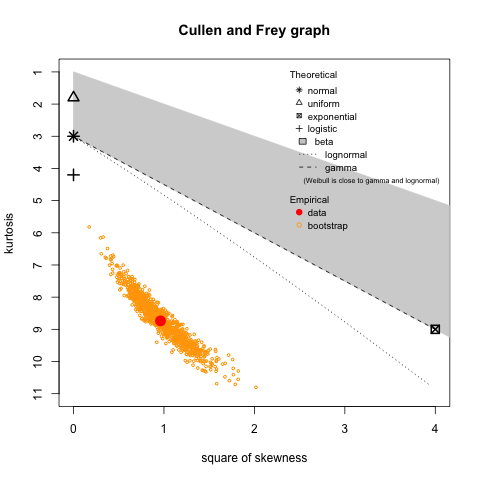

In [ ]:
%%R

# examine Cullen and Frey graph for log transformation
edu_data$l_Exam_Score <- log(edu_data$Exam_Score)
descdist(edu_data$l_Exam_Score, boot = 1000)
# examine Cullen and Frey graph for log transformation

<Axes: xlabel='l_Exam_Score', ylabel='Count'>

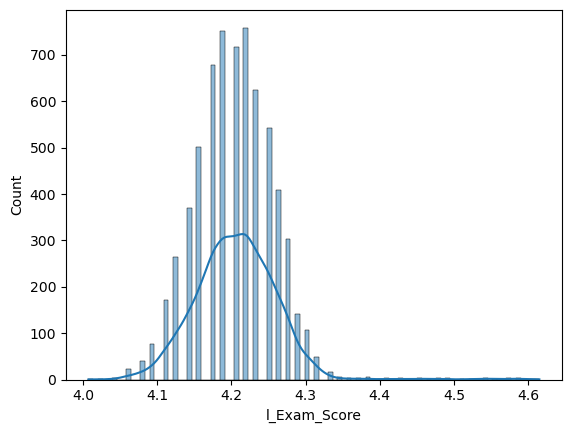

In [ ]:
sns.histplot(x = 'l_Exam_Score', data = data, kde = True)

The Box-Cox transformation improved the distribution, but as indicated by the position of the transformed data on the Cullen and Frey graph, due to the inherent nature of the `Exam_Score` data, its normality is not satisfactory and may still need further transformation. Thus, following the Box-Cox result `lambda = -2.61`, we performed a Box-Cox transformation with lambda = -2.61, aiming to achieve a more normal distribution:
$$
Y = \frac{Y^\lambda - 1}{\lambda} \phantom-
$$

According to graphs on the following, the new transformation reduced the high skewness and kurtosis in the original `Exam_Score` data, thus improved the distribution. With two rounds of transformation, ot can be concluded that, given the nature of exam scores (which may naturally contain more extreme low or high values), a perfect normal distribution is unlikely. Though an unexpected overlap with the logistic distribution is shown, now the Exam_Score data is sufficiently close to normality to allow for the use of linear regression.  


For `Exam_Score`'s proximity to logistic distribution, potential problems we may encounter are:
- The residuals may have heavier tails than a normal distribution, affecting p-values.
- Heteroscedasticity. We might see variance of residuals higher for extremely high or low values of `Exam_Score`.

In [ ]:
data['bc_Exam_Score'] = (data['Exam_Score']**(-2.61) - 1) / -2.61

summary statistics
------
min:  0.3831308   max:  0.3831395 
median:  0.3831352 
mean:  0.3831352 
estimated sd:  9.23815e-07 
estimated skewness:  -0.08182785 
estimated kurtosis:  4.353742 


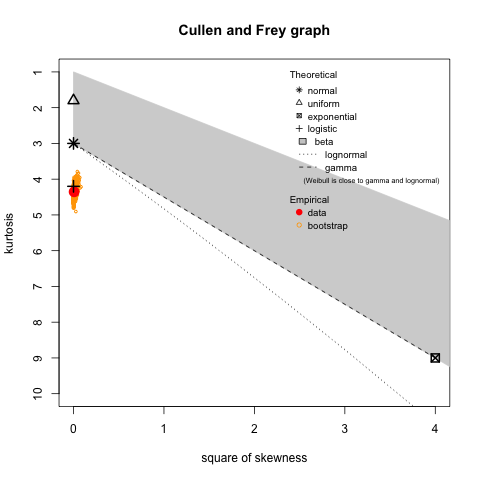

In [ ]:
%%R
# examine Cullen and Frey graph for BC transformation
edu_data$bc_Exam_Score <- (edu_data$Exam_Score^(-2.61) - 1) / -2.61
descdist(edu_data$bc_Exam_Score, boot = 1000)

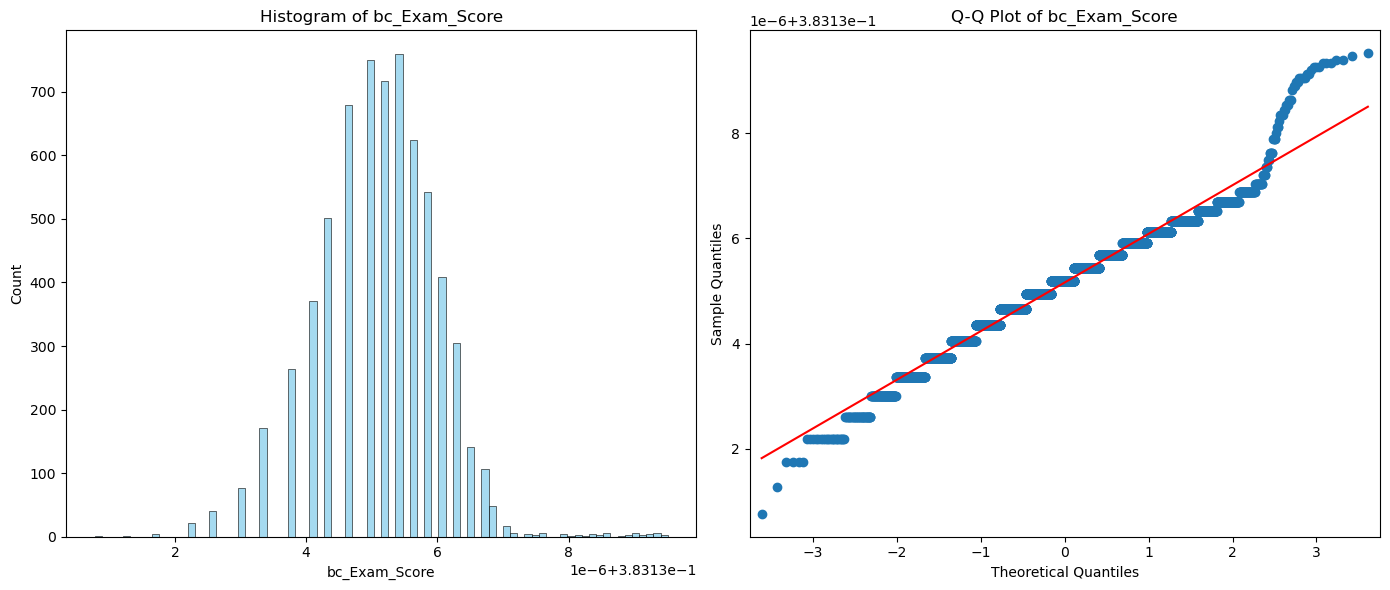

In [ ]:
# further examine histogram and qqplot for BC transformation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Histogram
sns.histplot(data['bc_Exam_Score'], kde=False, ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of bc_Exam_Score')
axes[0].set_xlabel('bc_Exam_Score')
axes[0].set_ylabel('Count')

# 2. Q-Q plot
sm.qqplot(data['bc_Exam_Score'], line='s', ax=axes[1])
axes[1].set_title('Q-Q Plot of bc_Exam_Score')

# Display the plots
plt.tight_layout()
plt.show()

## 7. Discussion on Outliners and Unusual Features

The histogram of all variables shows no outliners in the dataset.
- There are 4 variables that are not binary/trinary, `Hours_Studied`,`Attendance`,`Previous_Scores` and `Exam_Socre`.
- Except `Exam_score` other 3 variables are normal/uniform distributed with no outliners
- `Exam_Score`'s histogram shows there is no outliners

## 8. A Handling of NAs

The Null values are less than 2% of the whole dataset. Therefore we decide to leave out the missing values when conducting regression since it will not make a significant impact on the regression.

In [ ]:
data.isnull().sum()

Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
l_Exam_Score                   0
bc_Exam_Score                  0
dtype: int64

In [ ]:
data.count()

Hours_Studied                 6607
Attendance                    6607
Parental_Involvement          6607
Access_to_Resources           6607
Extracurricular_Activities    6607
Sleep_Hours                   6607
Previous_Scores               6607
Motivation_Level              6607
Internet_Access               6607
Tutoring_Sessions             6607
Family_Income                 6607
Teacher_Quality               6529
School_Type                   6607
Peer_Influence                6607
Physical_Activity             6607
Learning_Disabilities         6607
Parental_Education_Level      6517
Distance_from_Home            6540
Gender                        6607
Exam_Score                    6607
l_Exam_Score                  6607
bc_Exam_Score                 6607
dtype: int64

In [ ]:
data = data.dropna()

# II. Variable Selection

Boruta has confirmed variables `Hours_Studied`, `Attendance`, `Parental_Involvement`, `Access_to_Resources`, `Previous_Scores`, `Tutoring_Sessions`, and `Parental_Education_Level` as valuable for predicting the response variable `bc_Exam_Score`.

- The top 2 predictors are `Attendance` and `Hours_Studied`.

With a narrowed scope, we further conducted Mallows' Cp to double-confirm the top ideal predictors.

- The top 2 predictors are `Attendance` and `Hours_Studied`.

The result of Boruta and Mallow Cp match.


## 1. Predictor Identification with Boruta Algorithm


The downloaded binary packages are in
	/var/folders/x0/b35wdvkx53v091zhdsz4bm500000gn/T//RtmpATzod1/downloaded_packages
                               meanImp  medianImp       minImp    maxImp
Hours_Studied              25.46257479 25.4835886 23.245223155 27.942787
Attendance                 27.57533744 27.8628353 24.557853582 29.338406
Parental_Involvement        7.03998097  7.0966553  3.934994800 10.340691
Access_to_Resources         6.60844703  6.6736134  4.486695357  8.708448
Extracurricular_Activities  1.22410700  1.1664002 -0.741426578  3.967675
Sleep_Hours                -0.06992493 -0.3882539 -1.992670430  2.261187
Previous_Scores            10.04016066  9.9181157  8.330494842 12.190706
Motivation_Level            1.30371121  1.3503386 -1.520966566  3.413953
Internet_Access             0.87980271  0.9908671 -0.678485313  2.307924
Tutoring_Sessions           5.86938201  5.8329457  3.972978653  8.072818
Family_Income               1.53441353  1.7039505 -1.170058781  4.032490
Tea

also installing the dependency ‘ranger’

trying URL 'https://cran.case.edu/bin/macosx/big-sur-x86_64/contrib/4.4/ranger_0.16.0.tgz'
Content type 'application/x-gzip' length 2410187 bytes (2.3 MB)
downloaded 2.3 MB

trying URL 'https://cran.case.edu/bin/macosx/big-sur-x86_64/contrib/4.4/Boruta_8.0.0.tgz'
Content type 'application/x-gzip' length 454512 bytes (443 KB)
downloaded 443 KB

 1. run of importance source...
 2. run of importance source...
 3. run of importance source...
 4. run of importance source...
 5. run of importance source...
 6. run of importance source...
 7. run of importance source...
 8. run of importance source...
 9. run of importance source...
 10. run of importance source...
 11. run of importance source...
 12. run of importance source...
After 12 iterations, +35 secs: 
 confirmed 9 attributes: Access_to_Resources, Attendance, Exam_Score, Hours_Studied, l_Exam_Score and 4 more;
 rejected 2 attributes: Gender, Teacher_Quality;
 still have 10 attributes left.

 1

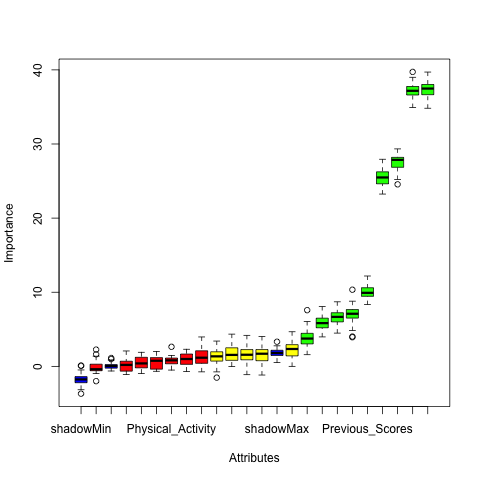

In [ ]:
%%R

library(Boruta)

set.seed(90095)
bc_edu_boruta <- Boruta(bc_Exam_Score ~ ., data = edu_data, doTrace = 2)

plot(bc_edu_boruta, sort = TRUE)
attStats(bc_edu_boruta)

Top 2 variable are `Attendance` and `Hours_Studied`. We put the top 4 important variables `Hours_Studied`, `Attendance`, `Previous_Score`, `Parental_Involvement` into Mallow CP to identify the best 2 perdictors.

## 2. Predictor Identification with Mallows Cp

Features: 16663/16663

Best subset: ['Hours_Studied', 'Attendance', 'Parental_Involvement', 'Access_to_Resources', 'Previous_Scores']


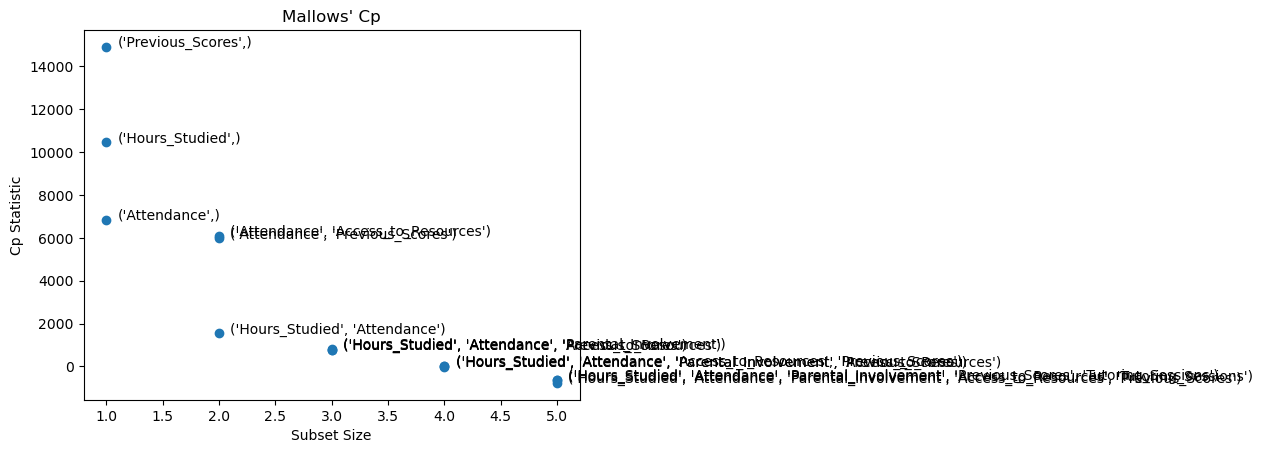

subsets  \
subsets                                                               
5       (Hours_Studied, Attendance, Parental_Involvemen...        5   
        (Hours_Studied, Attendance, Parental_Involvemen...        5   
        (Hours_Studied, Attendance, Parental_Involvemen...        5   
4       (Hours_Studied, Attendance, Parental_Involvemen...        4   
        (Hours_Studied, Attendance, Parental_Involvemen...        4   
        (Hours_Studied, Attendance, Access_to_Resources...        4   
3       (Hours_Studied, Attendance, Previous_Scores)              3   
        (Hours_Studied, Attendance, Access_to_Resources)          3   
        (Hours_Studied, Attendance, Parental_Involvement)         3   
2       (Hours_Studied, Attendance)                               2   
        (Attendance, Previous_Scores)                             2   
        (Attendance, Access_to_Resources)                         2   
1       (Attendance,)                                             1   
        (Hours_Studied,)                                          1   
        (Previous_Scores,)                                        1   

                                                                      Cp  
subsets                                                                   
5       (Hours_Studied, Attendance, Parental_Involvemen...   -773.026479  
        (Hours_Studied, Attendance, Parental_Involvemen...   -650.849002  
        (Hours_Studied, Attendance, Parental_Involvemen...   -634.869731  
4       (Hours_Studied, Attendance, Parental_Involvemen...     -7.727591  
        (Hours_Studied, Attendance, Parental_Involvemen...      5.000000  
        (Hours_Studied, Attendance, Access_to_Resources...     36.805316  
3       (Hours_Studied, Attendance, Previous_Scores)          770.124956  
        (Hours_Studied, Attendance, Access_to_Resources)      770.861851  
        (Hours_Studied, Attendance, Parental_Involvement)     807.521932  
2       (Hours_Studied, Attendance)                          1540.502820  
        (Attendance, Previous_Scores)                        5972.359526  
        (Attendance, Access_to_Resources)                    6081.432942  
1       (Attendance,)                                        6835.625452  
        (Hours_Studied,)                                    10452.894565  
        (Previous_Scores,)                                  14913.863458

In [ ]:
# First get some estimates from the full regression
score_full = smf.ols('bc_Exam_Score ~ Hours_Studied + Attendance + Parental_Involvement + Previous_Scores', data=data).fit()
score_full_sig2 = score_full.mse_resid # residual MSE = sigma^2 hat
score_n, _ = data.shape

# Negative Mallows' cp, so we want largest
def negative_mallows(estimator, X, y):
    y_pred = estimator.predict(X)
    sse = np.sum((y - y_pred) ** 2)
    p = estimator.n_features_in_ + 1 # number features doesn't include bias term
    cp = sse / score_full_sig2 + 2*p - score_n
    return -cp

# Set up regression
score_Y = data['bc_Exam_Score'].values
score_X = data.drop(['bc_Exam_Score', 'Exam_Score', 'l_Exam_Score'], axis=1)
lr = LinearRegression(fit_intercept=True)

# Using `ExhaustiveFeatureSelector` from `mlxtend`
score_efs = EFS(lr,
              min_features=1,
              max_features=5,
              scoring=negative_mallows,
              cv=None)

# Run regressions
score_efs.fit(score_X,score_Y)
print('Best subset:', [score_efs.feature_names[i] for i in score_efs.best_idx_])

# Extract Mallows' Cp data
score_efs_features = [score_efs.subsets_[p]['feature_names'] for p in score_efs.subsets_]
score_efs_subset = [len(score_efs.subsets_[p]['feature_idx']) for p in score_efs.subsets_]
score_efs_cp = [ -score_efs.subsets_[p]['avg_score'] for p in score_efs.subsets_]
score_mallows = pd.DataFrame({'subsets':score_efs_subset, 'Cp':score_efs_cp}, index=score_efs_features)

# Top 3 best, by subset
score_mallows_best = score_mallows.groupby('subsets')[['subsets','Cp']].apply(lambda x: x.nsmallest(3, 'Cp'))
score_mallows_best

# Plotting best subsets
plt.scatter(score_mallows_best['subsets'], score_mallows_best['Cp'])
plt.title("Mallows' Cp")
plt.xlabel('Subset Size')
plt.ylabel('Cp Statistic')
for i,sub in enumerate(score_mallows_best['subsets']):
    subset = score_mallows_best.index[i][1]
    plt.annotate(subset, (sub + 0.1, score_mallows_best.iloc[i]['Cp'] + 0.3)) # to plot labels
plt.show()

# And the associated sorted data frame
score_mallows_best.sort_values('Cp')


From the negetive Cp values we infer model with 5 predictors may have overfitting problem. The best 2 variable are`Attendance` and `Hours_studied` .


The downloaded binary packages are in
	/var/folders/x0/b35wdvkx53v091zhdsz4bm500000gn/T//RtmpATzod1/downloaded_packages


trying URL 'https://cran.case.edu/bin/macosx/big-sur-x86_64/contrib/4.4/leaps_3.2.tgz'
Content type 'application/x-gzip' length 104802 bytes (102 KB)
downloaded 102 KB



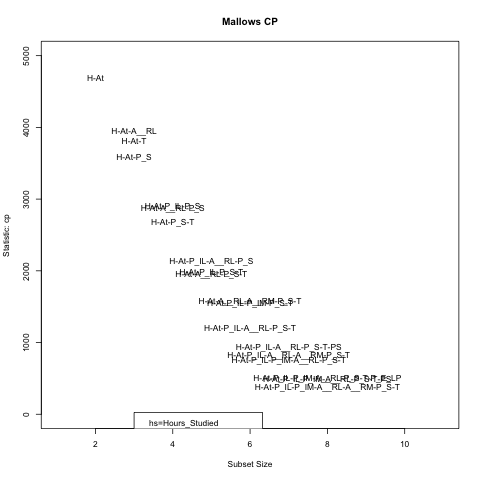

In [ ]:
%%R
install.packages("leaps")
library(leaps)

par(mfrow=c(1,1), cex=0.7)    # making the plot large and the text small to include all variable labels

edu_ss <- regsubsets(bc_Exam_Score ~ Hours_Studied + Attendance + Parental_Involvement + Previous_Scores, method = "exhaustive", nbest = 3, data = edu_data)
subsets(edu_ss, statistic = "cp", legend = FALSE, main = "Mallows CP", ylim = c(0, 5000))
legend(3, 25 ,bty = "y", legend = c('hs=Hours_Studied', 'ad=Attendance', 'pi=Parental_Involvement', 'ps=Previous_Scores'),
       col = "steelblue4", cex = 1)


# III. Model Building

## 1. Building Model

Based on the result of Boruta and Mallow Cp, we choose between 4 models:

1. Exam_Score ~ Attendance
2. Exam_Score ~ Hours_Studied
3. Box-Cox transformed Exam_Score ~ Attendance
4. Box-Cox transformed Exam_Score ~ Hours_Studied

In [ ]:
# model 1: Exam_Score ~ Attendance
model1 = smf.ols('Exam_Score ~ Attendance', data=data).fit()
print("Model 1 - Exam_Score on Attendance")
print(model1.summary())

# model 2: Exam_Score ~ Hours_Studied
model2 = smf.ols('Exam_Score ~ Hours_Studied', data=data).fit()
print("\nModel 2 - Exam_Score on Hours_Studied")
print(model2.summary())

# model 3: Box-Cox transformed Exam_Score ~ Attendance
model3 = smf.ols('bc_Exam_Score ~ Attendance', data=data).fit()
print("\nModel 3 - Box-Cox transformed Exam_Score on Attendance")
print(model3.summary())

# model 4: Box-Cox transformed Exam_Score ~ Hours_Studied
model4 = smf.ols('bc_Exam_Score ~ Hours_Studied', data=data).fit()
print("\nModel 4 - Box-Cox transformed Exam_Score on Hours_Studied")
print(model4.summary())

Model 1 - Exam_Score on Attendance
                            OLS Regression Results                            
Dep. Variable:             Exam_Score   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     3237.
Date:                Thu, 24 Oct 2024   Prob (F-statistic):               0.00
Time:                        21:06:37   Log-Likelihood:                -16444.
No. Observations:                6378   AIC:                         3.289e+04
Df Residuals:                    6376   BIC:                         3.291e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     51.

## 2. Evaluate transformations of variables

***Linearity***: All models support the assumption of linearity.

***Normality and Distribution***: All models show significant JB test results, indicating that residuals deviate from normality. Models 3 and 4 (Box-Cox transformations) exhibit logistic normality as we tested in the Cullen and Frey Graph. It's normal that the exam_score would not fit the normal distribution, may be because these students' performance could vary.

***Homoscedasticity***: Models 1 and 2 exhibit homoscedasticity, while Models 3 and 4 indicate heteroscedasticity. Because Model 3 and 4 subject to logistic distirbution.

***R square***: Modle3 > Model1 > Model4 > Model2. Model3 R ssuare = 0.401 means `Attendance`(after box-cox) can explain 40% variation of the `Exam_score`, which is the highest among 4 models.

In [ ]:

import statsmodels.stats.api as sms
from simple_colors import *

# define evaluate function
def evaluate_model(ols_fit):
    # Linearity: Harvey-Collier test
    name = ["t-stat", "p-value"]
    test = sms.linear_harvey_collier(ols_fit)
    print(blue("Linearity Test Results:", ['bold']))
    print(list(zip(name, test)))

    # Normality of residuals: Jarque-Bera test
    name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
    test = sms.jarque_bera(ols_fit.resid)
    print(blue("JB Results:", ['bold']))
    print(list(zip(name, test)))

    # Heteroskedasticity: Breusch-Pagan test
    name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
    test = sms.het_breuschpagan(ols_fit.resid, ols_fit.model.exog)
    print(blue("BP Results:", ['bold']))
    print(list(zip(name, test)))


print("Model 1 - Exam_Score on Attendance")
evaluate_model(model1)
print("\nModel 2 - Exam_Score on Hours_Studied")
evaluate_model(model2)
print("\nModel 3 - Box-Cox transformed Exam_Score on Attendance")
evaluate_model(model3)
print("\nModel 4 - Box-Cox transformed Exam_Score on Hours_Studied")
evaluate_model(model4)

Model 1 - Exam_Score on Attendance
Linearity Test Results:
[('t-stat', -1.2362857447853266), ('p-value', 0.21639792201061311)]
JB Results:
[('Jarque-Bera', 159935.30212211944), ('Chi^2 two-tail prob.', 0.0), ('Skew', 3.0805759674677105), ('Kurtosis', 26.74587052981866)]
BP Results:
[('Lagrange multiplier statistic', 0.05151102090557247), ('p-value', 0.8204545387478878), ('f-value', 0.051495284080845506), ('f p-value', 0.8204887741397925)]

Model 2 - Exam_Score on Hours_Studied
Linearity Test Results:
[('t-stat', 0.10083982453582926), ('p-value', 0.9196807841349175)]
JB Results:
[('Jarque-Bera', 82297.79849659327), ('Chi^2 two-tail prob.', 0.0), ('Skew', 2.361721620080052), ('Kurtosis', 19.952001583815825)]
BP Results:
[('Lagrange multiplier statistic', 0.7038728239934733), ('p-value', 0.4014854211440736), ('f-value', 0.7037297682726135), ('f p-value', 0.40156471797153315)]

Model 3 - Box-Cox transformed Exam_Score on Attendance
Linearity Test Results:
[('t-stat', -1.4221647390298986), 

## 3. Cook's Distance Plot
Despite a few instances of seemingly extreme value, the Cook's Distance are all below 1 in 4 models. That means no point has a significant influence on the regression model.

Original Model: ExamScore ~ Attendance


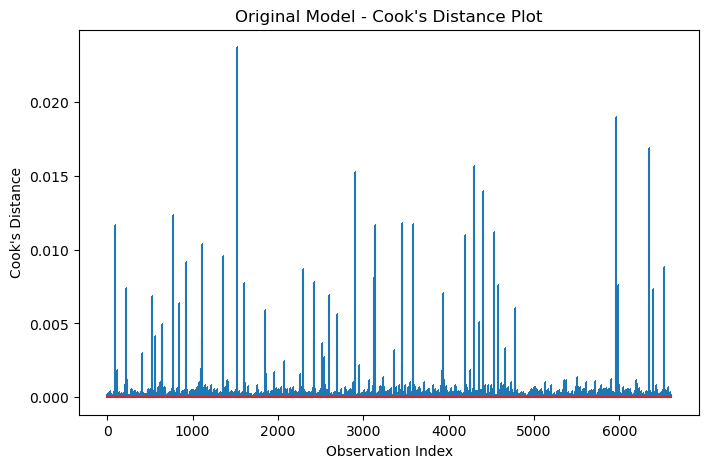

Original Model: ExamScore ~ Hours_Studied


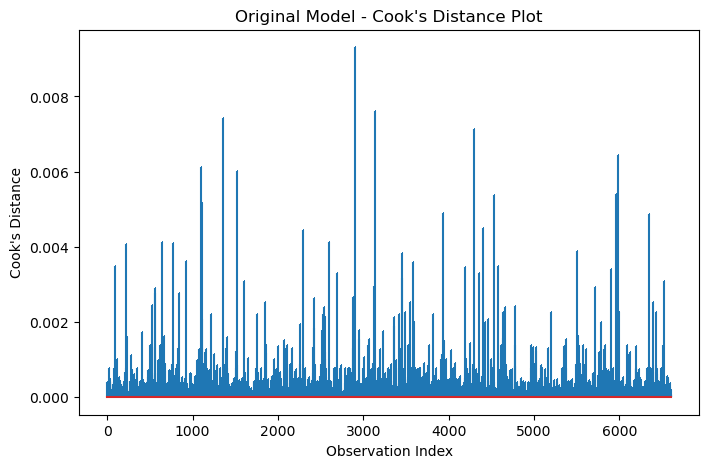

Box-Cox Transfer Model: ExamScore ~ Box-Cox transformed Attendance


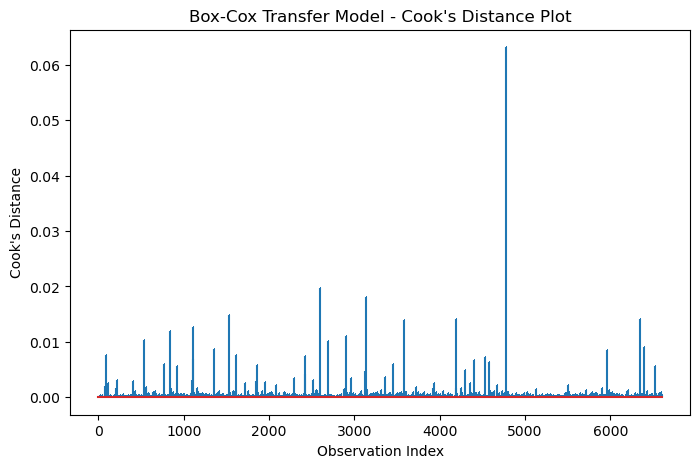

Box-Cox Transfer Model: ExamScore ~ Box-Cox transformed Hours_Studied


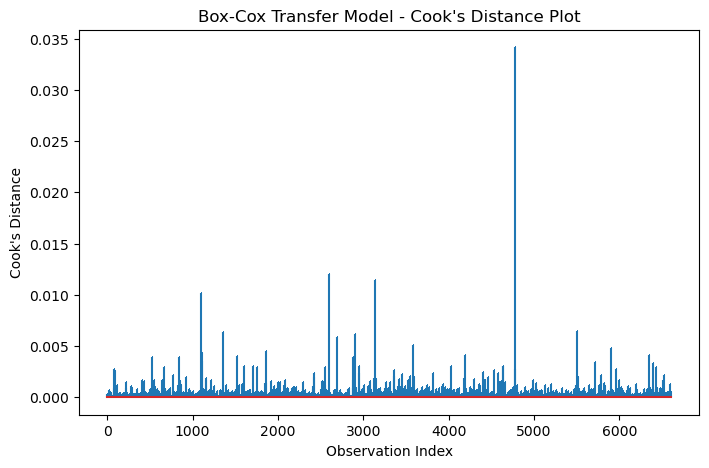

In [ ]:
# Function to plot diagnostics: Cook's Distance
def plot_CooksDistance(model, title_prefix):
    # Cook's Distance
    influence = model.get_influence()
    (c, p) = influence.cooks_distance

    # Plot Cook's Distance
    plt.figure(figsize=(8, 5))
    plt.stem(np.arange(len(c)), c, markerfmt=",")
    plt.title(f"{title_prefix} - Cook's Distance Plot")
    plt.xlabel('Observation Index')
    plt.ylabel('Cook\'s Distance')
    plt.show()


# print Cook's Distance for each model
print("Original Model: ExamScore ~ Attendance")
plot_CooksDistance(model1, "Original Model")
print("Original Model: ExamScore ~ Hours_Studied")
plot_CooksDistance(model3, "Original Model")
print("Box-Cox Transfer Model: ExamScore ~ Box-Cox transformed Attendance")
plot_CooksDistance(model2, "Box-Cox Transfer Model")
print("Box-Cox Transfer Model: ExamScore ~ Box-Cox transformed Hours_Studied")
plot_CooksDistance(model4, "Box-Cox Transfer Model")

## 4. Residuals Plot

The residuals should ideally be scattered randomly around the horizontal line without any clear pattern.
- For Model 1, the residuals exhibit some degree of heteroscedasticity at higher fitted values. The residuals are mostly clustered within the range of -5 to 5, but a number of points deviate significantly above this range.
- For Model 2, the residuals cluster around zero, and the scale on the y-axis suggests very small residuals.
- For Model 3, the residuals appear more uniformly spread across fitted values, suggesting the transformation has reduced heteroscedasticity. There appear to be fewer outliers in this model compared to the formerly discussed two.  However, the outliers remain, which means that the transformation hasn't completely handled them. This might suggest outliers are inherent to the dataset.
- For Model 4, the residuals seem to narrow as the fitted values increase, which is a strong sign of heteroscedasticity at higher fitted values.


Original Model: Exam_Score ~ Attendance


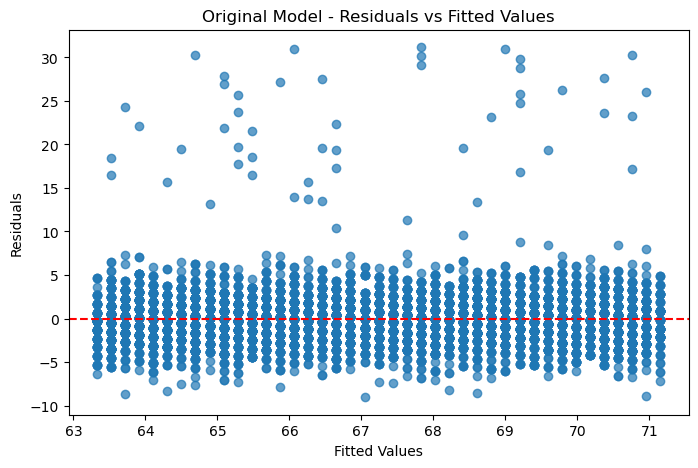

Original Model: Exam_Score ~ Hours_Studied


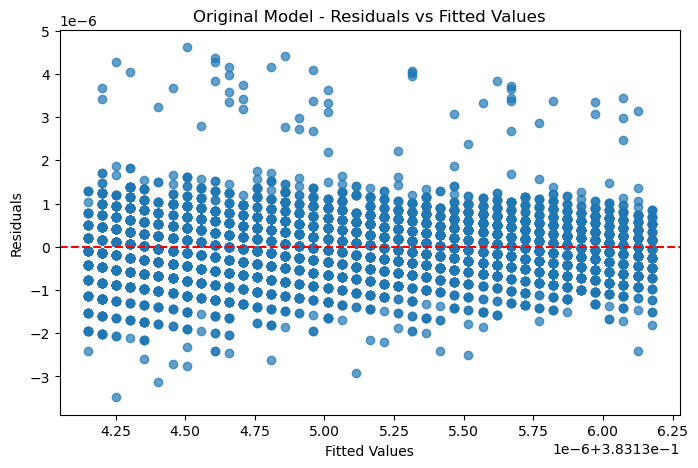

Box-Cox Transfer Model: Exam_Score ~ Box-Cox transformed Attendance


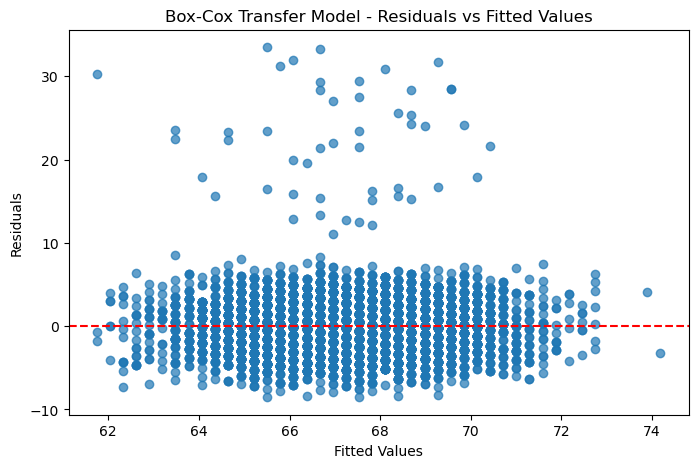

Box-Cox Transfer Model: Exam_Score ~ Box-Cox transformed Hours_Studied


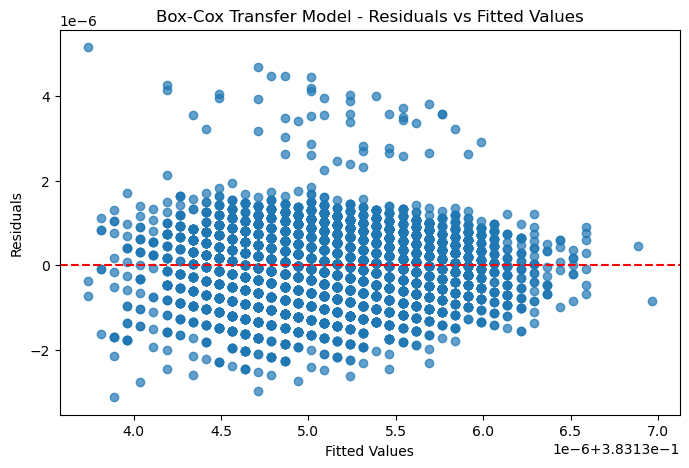

In [ ]:
# Function to plot diagnostics: Residuals Plot
def plot_ResidualsPlot(model, title_prefix):
    # Residuals Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(model.fittedvalues, model.resid, alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'{title_prefix} - Residuals vs Fitted Values')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.show()

# print residual plot for each model
print("Original Model: Exam_Score ~ Attendance")
plot_ResidualsPlot(model1, "Original Model")
print("Original Model: Exam_Score ~ Hours_Studied")
plot_ResidualsPlot(model3, "Original Model")
print("Box-Cox Transfer Model: Exam_Score ~ Box-Cox transformed Attendance")
plot_ResidualsPlot(model2, "Box-Cox Transfer Model")
print("Box-Cox Transfer Model: Exam_Score ~ Box-Cox transformed Hours_Studied")
plot_ResidualsPlot(model4, "Box-Cox Transfer Model")

## 5. Bootstrapping

All of the Bootstrapping models results above are approximately equal to the estimates in our LS models (confident intervals covered the estimates). Therefore, we could say that all of our estimates of LS models are robust.

The bootstrap result for Original Model: ExamScore ~ Attendance
                 mean       std     median   lower-95   upper-95
intercept   51.575658  0.270407  51.581281  51.053769  52.087945
Attendance   0.195801  0.003359   0.195790   0.189380   0.202206
r_squared    0.339095  0.015901   0.338531   0.310494   0.369973


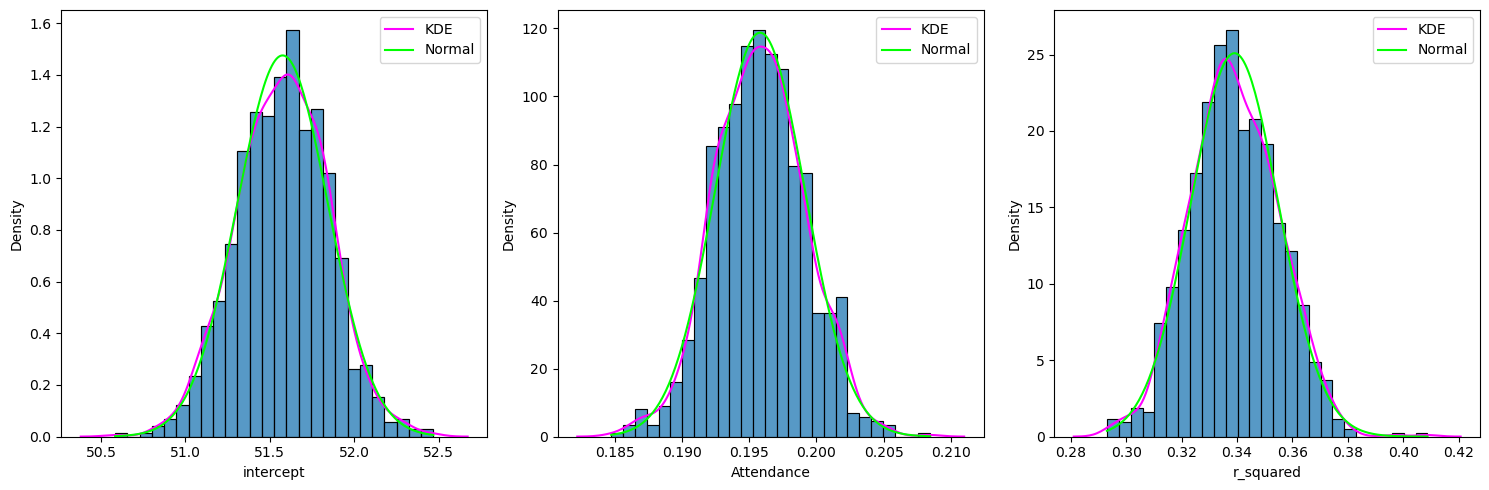

In [ ]:
# Define the dependent and independent variables
data_Y = data['Exam_Score']
data_X = data['Attendance']

# Sample data
np.random.seed(90095)

# Function to fit model and output parameters
def fitted_OLS(x, y):
    X = sm.add_constant(x)
    model = sm.OLS(endog=y, exog=X)
    fitted = model.fit()

    return fitted

# Run bootstrap
n_iterations = 1000
bootstrap_results = np.zeros((n_iterations, 3))  # Hold intercept, coefficient, and R^2
bootstrap_rsquared = []

for p in range(n_iterations):
    X_resampled, y_resampled = resample(data_X, data_Y)
    fitted = fitted_OLS(x=X_resampled, y=y_resampled)
    coefs = fitted.params
    r_squared = pd.Series(fitted.rsquared)
    # Store the intercept, coefficient, and R^2 in the bootstrap_results array
    bootstrap_results[p:] = pd.concat([coefs, r_squared])  # [intercept, coefficient, R^2]

# Create DataFrame for bootstrap results
data_bs = pd.DataFrame(bootstrap_results, columns=['intercept', 'Attendance', 'r_squared'])

# Summary statistics
data_bs_summary = data_bs.agg(['mean', 'std', 'median'], axis=0).T
data_bs_summary['lower-95'] = data_bs.apply(lambda x: np.quantile(x, 0.025))  # 2.5% lower bound
data_bs_summary['upper-95'] = data_bs.apply(lambda x: np.quantile(x, 0.975))  # 97.5% upper bound

# Display summary statistics
print('The bootstrap result for Original Model: ExamScore ~ Attendance')
print(data_bs_summary)
# Plotting bootstrapped estimates
fig10, ax10 = plt.subplots(1, 3, figsize=(15, 5))

for s in range(3):
    data_variable = data_bs_summary.iloc[s]
    estimate_name = data_bs.columns[s]
    estimate_range = np.linspace(min(data_bs[estimate_name]), max(data_bs[estimate_name]), 200)

    # Plot histogram and KDE
    sns.histplot(data_bs[estimate_name], stat='density', kde=False, ax=ax10[s])
    sns.kdeplot(data_bs[estimate_name], color='fuchsia', ax=ax10[s], label='KDE')
    sns.lineplot(x=estimate_range, y=norm.pdf(estimate_range, data_variable['mean'], data_variable['std']),
                 color='lime', ax=ax10[s], label='Normal')

plt.tight_layout()
plt.show()

The bootstrap result for Original Model: ExamScore ~ Hours_Studied
                    mean       std     median   lower-95   upper-95
intercept      61.454806  0.164828  61.459333  61.137142  61.802222
Hours_Studied   0.289415  0.007760   0.289313   0.273835   0.304316
r_squared       0.199377  0.012626   0.199525   0.174536   0.224377


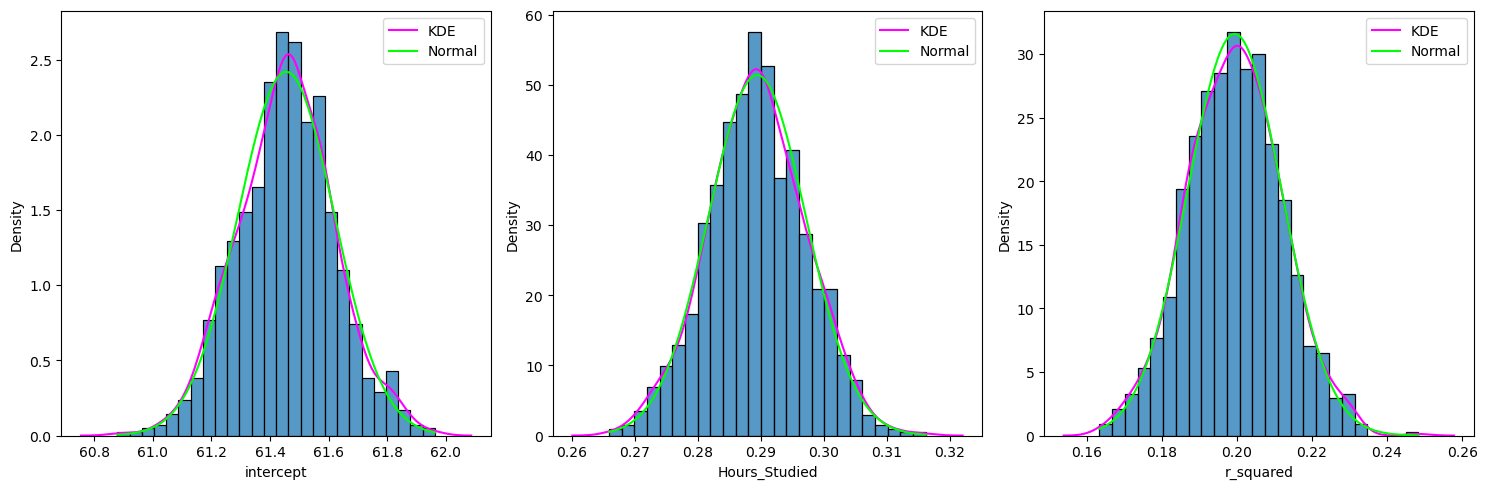

In [ ]:
# Define the dependent and independent variables
data_Y = data['Exam_Score']
data_X = data['Hours_Studied']

# Sample data
np.random.seed(90095)

# Function to fit model and output parameters
def fitted_OLS(x, y):
    X = sm.add_constant(x)
    model = sm.OLS(endog=y, exog=X)
    fitted = model.fit()

    return fitted

# Run bootstrap
n_iterations = 1000
bootstrap_results = np.zeros((n_iterations, 3))  # Hold intercept, coefficient, and R^2
bootstrap_rsquared = []

for p in range(n_iterations):
    X_resampled, y_resampled = resample(data_X, data_Y)
    fitted = fitted_OLS(x=X_resampled, y=y_resampled)
    coefs = fitted.params
    r_squared = pd.Series(fitted.rsquared)
    # Store the intercept, coefficient, and R^2 in the bootstrap_results array
    bootstrap_results[p:] = pd.concat([coefs, r_squared])  # [intercept, coefficient, R^2]

# Create DataFrame for bootstrap results
data_bs = pd.DataFrame(bootstrap_results, columns=['intercept', 'Hours_Studied', 'r_squared'])

# Summary statistics
data_bs_summary = data_bs.agg(['mean', 'std', 'median'], axis=0).T
data_bs_summary['lower-95'] = data_bs.apply(lambda x: np.quantile(x, 0.025))  # 2.5% lower bound
data_bs_summary['upper-95'] = data_bs.apply(lambda x: np.quantile(x, 0.975))  # 97.5% upper bound

# Display summary statistics
print('The bootstrap result for Original Model: ExamScore ~ Hours_Studied')
print(data_bs_summary)

# Plotting bootstrapped estimates
fig10, ax10 = plt.subplots(1, 3, figsize=(15, 5))

for s in range(3):
    data_variable = data_bs_summary.iloc[s]
    estimate_name = data_bs.columns[s]
    estimate_range = np.linspace(min(data_bs[estimate_name]), max(data_bs[estimate_name]), 200)

    # Plot histogram and KDE
    sns.histplot(data_bs[estimate_name], stat='density', kde=False, ax=ax10[s])
    sns.kdeplot(data_bs[estimate_name], color='fuchsia', ax=ax10[s], label='KDE')
    sns.lineplot(x=estimate_range, y=norm.pdf(estimate_range, data_variable['mean'], data_variable['std']),
                 color='lime', ax=ax10[s], label='Normal')

plt.tight_layout()
plt.show()

The bootstrap result for Box-Cox Transformed Model: bc_ExamScore ~ Attendance
                    mean           std        median      lower-95  \
intercept   3.831311e-01  6.679293e-08  3.831311e-01  3.831310e-01   
Attendance  5.084540e-08  7.990445e-10  5.081503e-08  4.937664e-08   
r_squared   4.011293e-01  1.141176e-02  4.013069e-01  3.795752e-01   

                upper-95  
intercept   3.831312e-01  
Attendance  5.251820e-08  
r_squared   4.244703e-01  


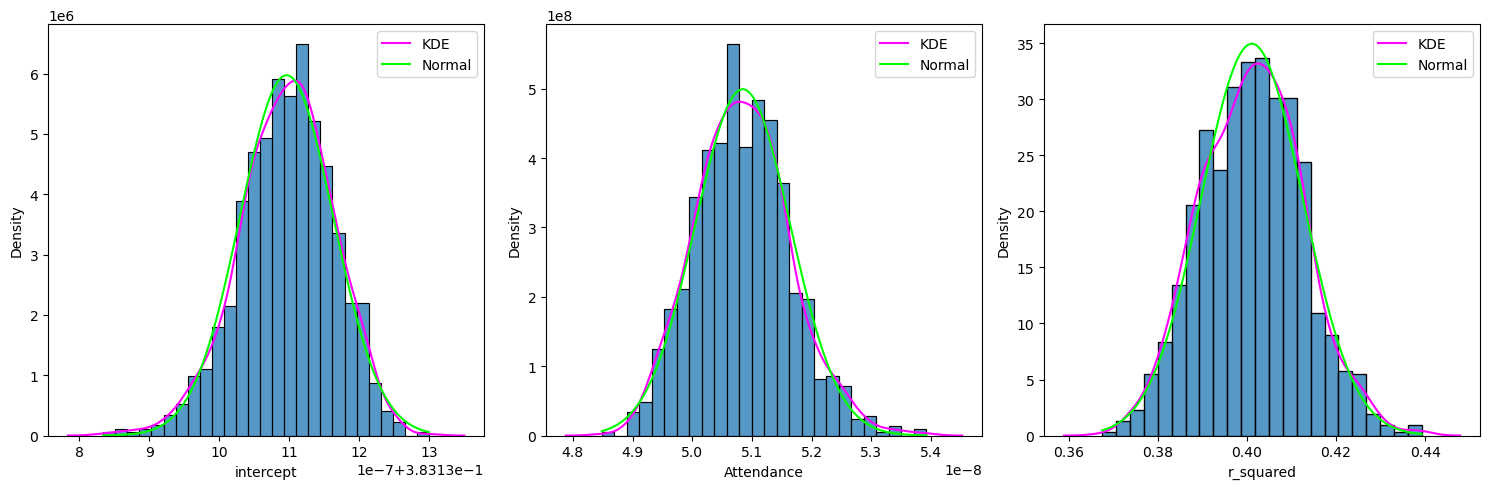

In [ ]:
# Define the dependent and independent variables
data_Y = data['bc_Exam_Score']
data_X = data['Attendance']

# Sample data
np.random.seed(90095)

# Function to fit model and output parameters
def fitted_OLS(x, y):
    X = sm.add_constant(x)
    model = sm.OLS(endog=y, exog=X)
    fitted = model.fit()

    return fitted

# Run bootstrap
n_iterations = 1000
bootstrap_results = np.zeros((n_iterations, 3))  # Hold intercept, coefficient, and R^2
bootstrap_rsquared = []

for p in range(n_iterations):
    X_resampled, y_resampled = resample(data_X, data_Y)
    fitted = fitted_OLS(x=X_resampled, y=y_resampled)
    coefs = fitted.params
    r_squared = pd.Series(fitted.rsquared)
    # Store the intercept, coefficient, and R^2 in the bootstrap_results array
    bootstrap_results[p:] = pd.concat([coefs, r_squared])  # [intercept, coefficient, R^2]

# Create DataFrame for bootstrap results
data_bs = pd.DataFrame(bootstrap_results, columns=['intercept', 'Attendance', 'r_squared'])

# Summary statistics
data_bs_summary = data_bs.agg(['mean', 'std', 'median'], axis=0).T
data_bs_summary['lower-95'] = data_bs.apply(lambda x: np.quantile(x, 0.025))  # 2.5% lower bound
data_bs_summary['upper-95'] = data_bs.apply(lambda x: np.quantile(x, 0.975))  # 97.5% upper bound

# Display summary statistics
print('The bootstrap result for Box-Cox Transformed Model: bc_ExamScore ~ Attendance')
print(data_bs_summary)
# Plotting bootstrapped estimates
fig10, ax10 = plt.subplots(1, 3, figsize=(15, 5))

for s in range(3):
    data_variable = data_bs_summary.iloc[s]
    estimate_name = data_bs.columns[s]
    estimate_range = np.linspace(min(data_bs[estimate_name]), max(data_bs[estimate_name]), 200)

    # Plot histogram and KDE
    sns.histplot(data_bs[estimate_name], stat='density', kde=False, ax=ax10[s])
    sns.kdeplot(data_bs[estimate_name], color='fuchsia', ax=ax10[s], label='KDE')
    sns.lineplot(x=estimate_range, y=norm.pdf(estimate_range, data_variable['mean'], data_variable['std']),
                 color='lime', ax=ax10[s], label='Normal')

plt.tight_layout()
plt.show()

The bootstrap result for Box-Cox Transformed Model: bc_ExamScore ~ Hours_Studied
                       mean           std        median      lower-95  \
intercept      3.831337e-01  3.868692e-08  3.831337e-01  3.831336e-01   
Hours_Studied  7.545289e-08  1.779168e-09  7.538691e-08  7.206051e-08   
r_squared      2.374063e-01  1.029484e-02  2.375547e-01  2.185426e-01   

                   upper-95  
intercept      3.831337e-01  
Hours_Studied  7.902475e-08  
r_squared      2.582636e-01  


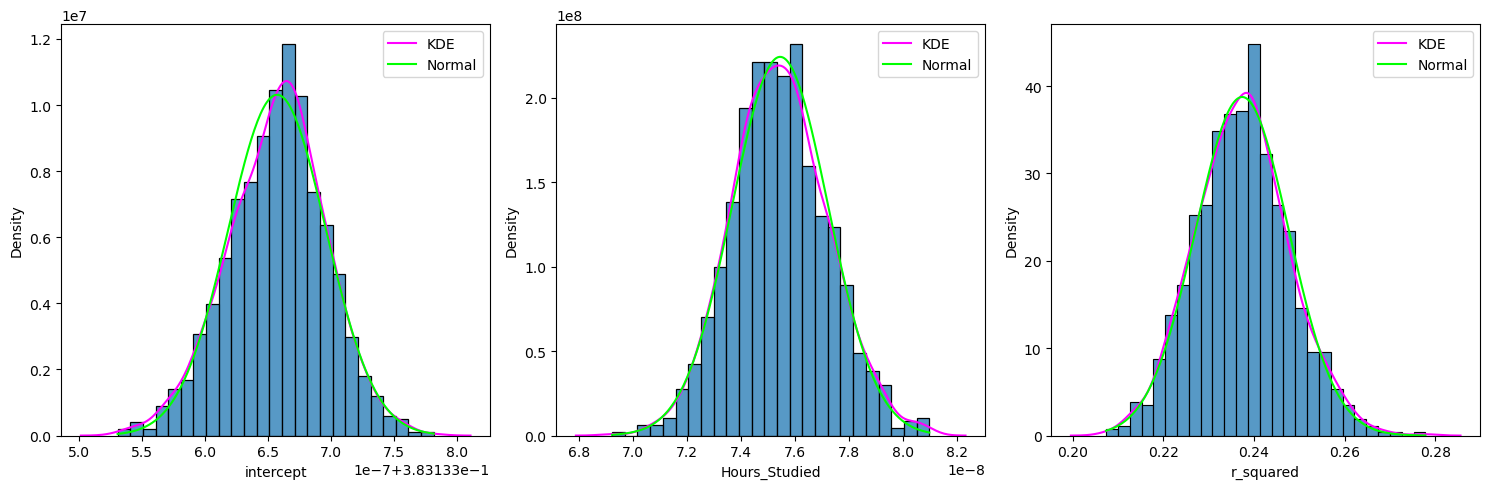

In [ ]:
# Define the dependent and independent variables
data_Y = data['bc_Exam_Score']
data_X = data['Hours_Studied']

# Sample data
np.random.seed(90095)

# Function to fit model and output parameters
def fitted_OLS(x, y):
    X = sm.add_constant(x)
    model = sm.OLS(endog=y, exog=X)
    fitted = model.fit()

    return fitted

# Run bootstrap
n_iterations = 1000
bootstrap_results = np.zeros((n_iterations, 3))  # Hold intercept, coefficient, and R^2
bootstrap_rsquared = []

for p in range(n_iterations):
    X_resampled, y_resampled = resample(data_X, data_Y)
    fitted = fitted_OLS(x=X_resampled, y=y_resampled)
    coefs = fitted.params
    r_squared = pd.Series(fitted.rsquared)
    # Store the intercept, coefficient, and R^2 in the bootstrap_results array
    bootstrap_results[p:] = pd.concat([coefs, r_squared])  # [intercept, coefficient, R^2]

# Create DataFrame for bootstrap results
data_bs = pd.DataFrame(bootstrap_results, columns=['intercept', 'Hours_Studied', 'r_squared'])

# Summary statistics
data_bs_summary = data_bs.agg(['mean', 'std', 'median'], axis=0).T
data_bs_summary['lower-95'] = data_bs.apply(lambda x: np.quantile(x, 0.025))  # 2.5% lower bound
data_bs_summary['upper-95'] = data_bs.apply(lambda x: np.quantile(x, 0.975))  # 97.5% upper bound

# Display summary statistics
print('The bootstrap result for Box-Cox Transformed Model: bc_ExamScore ~ Hours_Studied')
print(data_bs_summary)
# Plotting bootstrapped estimates
fig10, ax10 = plt.subplots(1, 3, figsize=(15, 5))

for s in range(3):
    data_variable = data_bs_summary.iloc[s]
    estimate_name = data_bs.columns[s]
    estimate_range = np.linspace(min(data_bs[estimate_name]), max(data_bs[estimate_name]), 200)

    # Plot histogram and KDE
    sns.histplot(data_bs[estimate_name], stat='density', kde=False, ax=ax10[s])
    sns.kdeplot(data_bs[estimate_name], color='fuchsia', ax=ax10[s], label='KDE')
    sns.lineplot(x=estimate_range, y=norm.pdf(estimate_range, data_variable['mean'], data_variable['std']),
                 color='lime', ax=ax10[s], label='Normal')

plt.tight_layout()
plt.show()

## 6. Cross Validation
After reviewing the K-fold Cross-Validation results of the four models, all the models indicates relatively close results of Train RMSE, Test RMSE, and Overall CV RMSE. We could possibly say that our model is well-performed.

Model: Exam_Score ~ Attendance
Train RMSE (mean): 3.1656563403065716
Test RMSE (mean): 3.1630045267516875
RMSE for each CV fold: [3.164576125069357, 3.0885119315884575, 3.4501135525998654, 2.973215610978124, 3.138605413522637]
Overall mean CV RMSE: 3.1630045267516875
Intercepts (mean): 51.57793122404331
Coefficients (mean): 0.1957772081231437



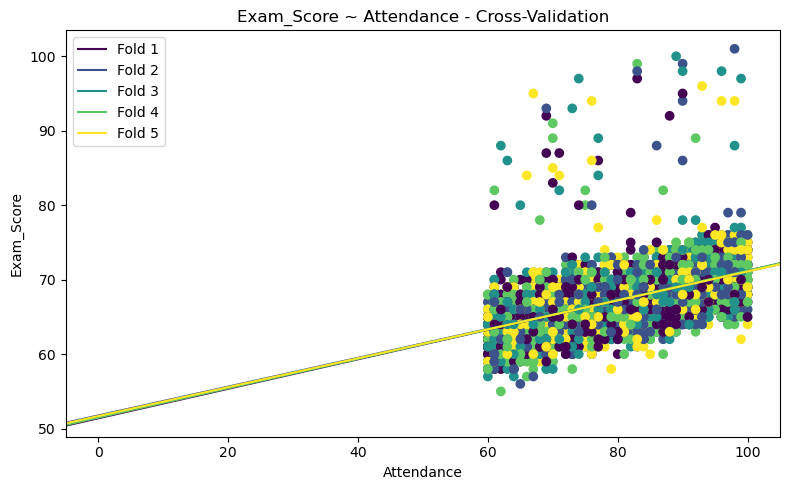

Model: Exam_Score ~ Hours_Studied
Train RMSE (mean): 3.4825419599622456
Test RMSE (mean): 3.4825333825230693
RMSE for each CV fold: [3.48158574581171, 3.4773627418619752, 3.702495934340215, 3.3378751762646477, 3.413347314336797]
Overall mean CV RMSE: 3.4825333825230693
Intercepts (mean): 61.45594486255898
Coefficients (mean): 0.28933604123376744



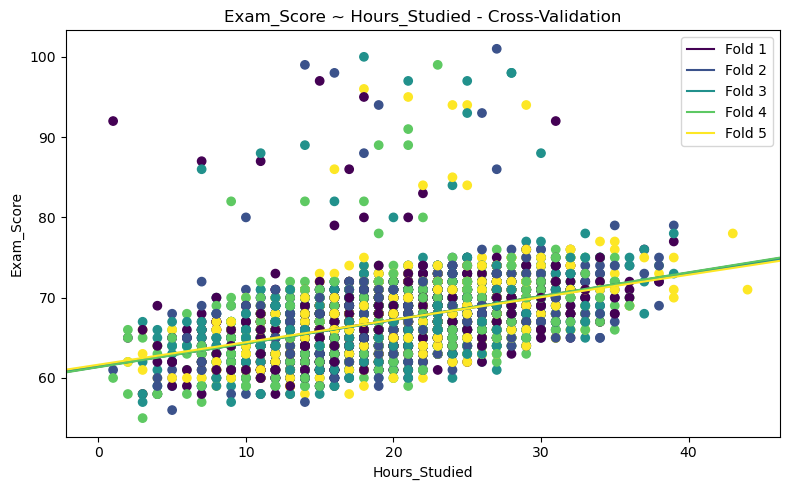

Model: bc_Exam_Score ~ Attendance
Train RMSE (mean): 7.155287216893538e-07
Test RMSE (mean): 7.154729748109231e-07
RMSE for each CV fold: [7.283686670969756e-07, 6.859972449576396e-07, 7.417346708197837e-07, 7.093333693854832e-07, 7.119309217947327e-07]
Overall mean CV RMSE: 7.154729748109231e-07
Intercepts (mean): 0.38313111524572935
Coefficients (mean): 5.0596013353476265e-08



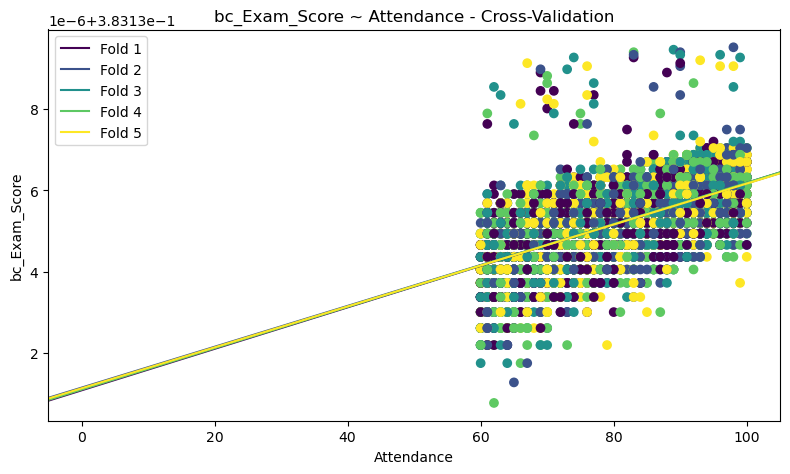

Model: bc_Exam_Score ~ Hours_Studied
Train RMSE (mean): 8.070507320546267e-07
Test RMSE (mean): 8.073460569592822e-07
RMSE for each CV fold: [8.16576737259551e-07, 7.945048072510579e-07, 8.241064623863305e-07, 8.105267665364426e-07, 7.910155113630296e-07]
Overall mean CV RMSE: 8.073460569592822e-07
Intercepts (mean): 0.3831336631344459
Coefficients (mean): 7.502298343238038e-08



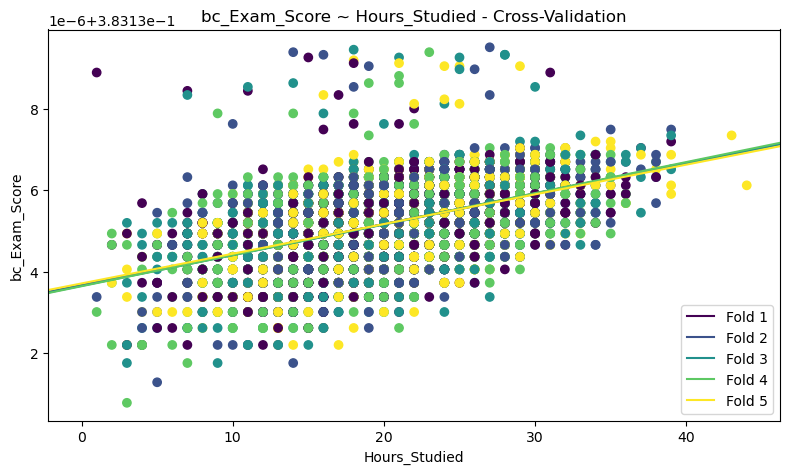

In [ ]:
# Define models
models = [
    {'y': data['Exam_Score'], 'X': data[['Attendance']], 'name': 'Exam_Score ~ Attendance'},
    {'y': data['Exam_Score'], 'X': data[['Hours_Studied']], 'name': 'Exam_Score ~ Hours_Studied'},
    {'y': data['bc_Exam_Score'], 'X': data[['Attendance']], 'name': 'bc_Exam_Score ~ Attendance'},
    {'y': data['bc_Exam_Score'], 'X': data[['Hours_Studied']], 'name': 'bc_Exam_Score ~ Hours_Studied'}
]

# Initialize KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=10)

# Loop over each model
for model_info in models:
    X = model_info['X'].to_numpy().reshape(-1, 1)  # Convert to numpy array for sklearn
    y = model_info['y']
    model_name = model_info['name']

    # Initialize lists for RMSE and coefficients
    rmse_list = []           # List to hold Test RMSE for each fold
    train_rmse_list = []     # List to hold Train RMSE for each fold
    intercept_list = []
    coefficient_list = []

    # Perform cross-validation
    fold_assignments = np.zeros(len(y))
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        fold_assignments[test_index] = fold

        # Split into train and test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit model and make predictions
        model = LinearRegression().fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)  # Predictions on the training set

        # Calculate RMSE for the fold
        fold_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
        train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

        # Append to lists
        rmse_list.append(fold_rmse)
        train_rmse_list.append(train_rmse)
        intercept_list.append(model.intercept_)
        coefficient_list.append(model.coef_[0])  # Single coefficient

    # Output the cross-validation results
    print(f"Model: {model_name}")
    print(f"Train RMSE (mean): {np.mean(train_rmse_list)}")
    print(f"Test RMSE (mean): {np.mean(rmse_list)}")
    print(f"RMSE for each CV fold: {rmse_list}")
    print(f"Overall mean CV RMSE: {np.mean(rmse_list)}")
    print(f"Intercepts (mean): {np.mean(intercept_list)}")
    print(f"Coefficients (mean): {np.mean(coefficient_list)}\n")

    # Plot the scatter plot with fold assignments and best-fit lines
    fold_c = ['#440154FF', '#3B528BFF', '#21908CFF', '#5DC863FF', '#FDE725FF']
    plt.figure(figsize=(8, 5))
    plt.scatter(x=X, y=y, c=fold_assignments, cmap='viridis')

    for i, params in enumerate(zip(intercept_list, coefficient_list)):
        plt.axline(xy1=(0, params[0]), slope=params[1], color=fold_c[i], label=f'Fold {i+1}')

    plt.ylabel(model_info['y'].name)
    plt.xlabel(model_info['X'].columns[0])
    plt.title(f'{model_name} - Cross-Validation')
    plt.legend()
    plt.tight_layout()
    plt.show()

# IV. Conclusion
We’ve chosen Model 3, the Box-Cox transformed Attendence model as the best option. Where,

$$
\text{bc_Exam_Score} = 0.3831 + (5.084 \times 10^{-8}) \times \text{Attendance}
$$

We could also retransform the function as,

$$
\text{Exam_Score} = \left(0.3831 + (5.084 \times 10^{-8}) \times \text{Attendance} \times \lambda + 1\right)^{\frac{1}{\lambda}}
$$

- $\lambda$ is the Box-Cox transformation parameter, which equals to -2.61.

- **Intercept**: The intercept is 0.3831, representing the base level of `bc_Exam_Score` when `Attendance` is 0. This value also could be interpreted as (if we dretransform) the predicted Exam score when there is no attendance.
  
- **Attendance Coefficient**: The coefficient for `Attendance` is 5.084 × 10⁻⁸, a slight increase in the transformed `bc_Exam_Score` for each additional unit increase in `Attendance`.

- **R-squared**: The R-squared value of 0.401 suggests that approximately 40.1% of the variance in `bc_Exam_Score` is explained by `Attendance`.

- **F-statistic and p-value**: With an F-statistic of 4270 and a p-value of 0.00, the model is statistically significant, meaning `Attendance` is a meaningful predictor of `bc_Exam_Score`.

- **AIC and BIC**: The AIC is -162400 and the BIC is -162300. These low values of AIC and BIC indicate that the model is a better-fitting model.


The chosen model has a higher R-squared, more concentrated residuals, handles non-linearity well, and is strongly robust based on Bootstrap results.




### 1. Higher R-squared
After the Box-Cox transformation, the R-squared went up to 0.40, which is way better than the 0.198 in the untransformed model. This means the transformed model explains 40% of the variation in exam scores, while the untransformed one only explains 19.8%. A higher R-squared shows that the model does a better job capturing what affects student performance, especially when it comes to study hours, making it a valuable tool for decision-makers.

### 2. More Concentrated Residuals
The residuals in the Box-Cox transformed model are more tightly grouped and evenly distributed, showing that it’s more reliable in terms of prediction. This concentration means the model handles outliers better and gives more accurate predictions for most students, which makes it more trustworthy.

### 3. Handling Non-linear Relationships
The Box-Cox transformation helps deal with non-linearities between study hours and scores, making the model more adaptable to different student learning patterns. This flexibility is key for education, as it allows schools to develop more tailored support strategies based on individual student needs.

### 4. Robustness
The Box-Cox transformed model, as confirmed by Bootstrap validation, shows narrower confidence intervals, meaning it stays stable across different datasets and is less affected by outliers. This robustness ensures that even if the student population changes, the model can still reliably predict exam scores.
